# Research Paper Classification for COVID-19 Research

There has been great momentum from the machine learning community to extract insights from the increasingly growing COVID-19 Datasets.

We believe the most powerful insights can be brought through cross-functional collaboration between infectious disease experts and machine learning practitioners. 

More importantly, once powerful predictive and explanatory models are built, it is especially important to be able to enable access to these models at scale.

In this small tutorial we will show how you can deploy your machine learning solutions at scale, and we will use a practical example with an on-going Kaggle dataset released by the Allen Institute for AI containing over 44,000 scholarly articles on COVID-19.

In this tutorial we will deploy a COVID-19 research paper classifier using Seldon Core, which will allow us to convert this ML model into a fully fledged microservice, which we'll be able to send REST / GRPC requests, as well as monitor through grafana / ELK integration.

## Tutorial Overview

In this tutorial we will showcase an end-to-end workflow that will ultimately show how to deploy a machine learning model - in this case we will be building a classifier that identifies whether a research paper is related to covid-19.

The steps in this tutorial include:

1) Train and build your NLP model

2) Build your containerized model

3) Test your model as a docker container

4) Run Seldon in your kubernetes cluster

5) Deploy your model with Seldon

6) Interact with your model through API

7) Clean your environment


### Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* Python 3.6+
* Python DEV requirements (we'll install them below)

Let's get started! 🚀🔥

## 1) Train and build your NLP model

In [100]:
%%writefile requirements-dev.txt
scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9
xai==0.0.5

Writing requirements-dev.txt


In [ ]:
# Let's first install any dependencies
!pip install -r requirements-dev.txt

In [6]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from seldon_core.seldon_client import SeldonClient
import dill
import sys, os
import xai

# This import may take a while as it will download the Spacy ENGLISH model
from ml_utils import CleanTextTransformer, SpacyTokenTransformer


    Linking successful
    /home/alejandro/miniconda3/lib/python3.7/site-packages/en_core_web_sm
    -->
    /home/alejandro/miniconda3/lib/python3.7/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [69]:
arxiv_df = pd.read_csv("./data/arxiv-abstracts-2k.txt", names=["abstract", "is_covid"], delimiter= '\$\$\$')
arxiv_df.is_covid = [0]*2000
covid_df = pd.read_csv("./data/cord_19_2k.txt", names=["abstract", "is_covid"], delimiter= '\$\$\$')
covid_df.is_covid = [1]*2000

/home/alejandro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/alejandro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
df = arxiv_df.append(covid_df)

In [71]:
df.to_csv("./data/research_paper_abstracts.csv", index=False)

In [72]:
df = pd.read_csv("./data/research_paper_abstracts.csv")

In [73]:
df.tail()

,abstract,is_covid
3995,Abstract This article summarizes current knowl...,1
3996,Abstract While epidemiological models have tra...,1
3997,Abstract TGEV and PEDV are porcine coronavirus...,1
3998,"Abstract Metagenomics, i.e., the sequencing an...",1
3999,Abstract Population genetic diversity plays a ...,1


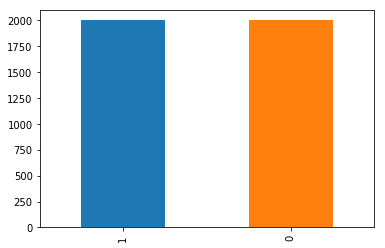

In [74]:
# Let's see how many examples we have of each class
df["is_covid"].value_counts().plot.bar()

In [75]:
x = df["abstract"].values
y = df["is_covid"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

In [80]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

/home/alejandro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [81]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

In [82]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x, 
    tokenizer=lambda x: x, 
    token_pattern=None,
    ngram_range=(1, 3))

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function <lambda> at 0x7fe4b5902050>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=None,
        tokenizer=<function <lambda> at 0x7fe4b58e6cb0>, use_idf=True,
        vocabulary=None)

In [83]:
# Transform our tokens to tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(
    x_train_tokenized)

In [84]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver='sag')
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
pred = lr.predict(tfidf_vectorizer.transform(spacy_tokenizer.transform(clean_text_transformer.transform(x_test))))

/home/alejandro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


,target
precision,0.994924
recall,0.980000
specificity,0.995000
accuracy,0.987500
auc,0.987500
f1,0.987406


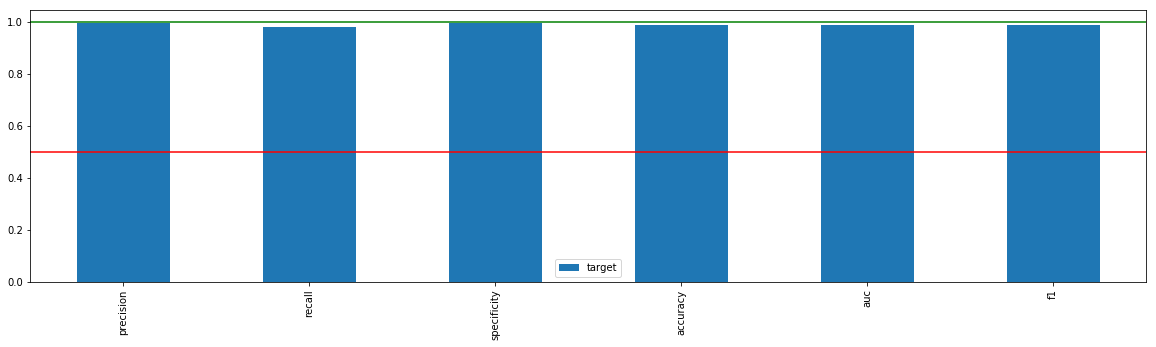

In [101]:
xai.metrics_plot(y_test, pred)

## 2) Build your containerized model

First we need to export the trained models

In [112]:
# These are the models we'll deploy
with open('tfidf_vectorizer.model', 'wb') as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open('lr.model', 'wb') as model_file:
    dill.dump(lr, model_file)

Now we write a class wrapper to expose the models

In [108]:
%%writefile ResearchClassifier.py

import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer

class ResearchClassifier(object):
    def __init__(self):
        
        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()
        
        with open('tfidf_vectorizer.model', 'rb') as model_file:
            self._tfidf_vectorizer = dill.load(model_file)
           
        with open('lr.model', 'rb') as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions



Overwriting ResearchClassifier.py


In [115]:
# test that our model works
from ResearchClassifier import ResearchClassifier
# With one sample
sample = x_test[0:1]
print(sample)
print(RedditClassifier().predict(sample, ["feature_name"]))
print(y_test[0:1])

['We report theoretical and simulation studies of phase coexistence in model globular protein solutions, based on short-range, central, pair potential representations of the interaction among macro-particles. After reviewing our previous investigations of hard-core Yukawa and generalised Lennard-Jones potentials, we report more recent results obtained within a DLVO-like description of lysozyme solutions in water and added salt. We show that a one-parameter fit of this model based on Static Light Scattering and Self-Interaction Chromatography data in the dilute protein regime, yields demixing and crystallization curves in good agreement with experimental protein-rich/protein-poor and solubility envelopes. The dependence of cloud and solubility points temperature of the model on the ionic strength is also investigated. Our findings highlight the minimal assumptions on the properties of the microscopic interaction sufficient for a satisfactory reproduction of the phase diagram topology of

### Create Docker Image with the S2i utility
Using the S2I command line interface we wrap our current model to seve it through the Seldon interface

In [35]:
# To create a docker image we need to create the .s2i folder configuration as below:
!cat .s2i/environment

MODEL_NAME=RedditClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


In [116]:
%%writefile requirements.txt
scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9

Overwriting requirements.txt


In [ ]:
!s2i build . seldonio/seldon-core-s2i-python3:0.18 research-classifier:0.1

## 3) Test your model as a docker container

In [38]:
# Remove previously deployed containers for this model
!docker rm -f research_predictor

Error: No such container: reddit_predictor


In [39]:
!docker run --name "research_predictor" -d --rm -p 5001:5000 research-classifier:0.1

be29c6a00adec0f708dc5a1c83613e0656fddc06daba4ca02d93b5a7ece9b92b


### Make sure you wait for language model
SpaCy will download the English language model, so you have to make sure the container finishes downloading it before it can be used. You can view this by running the logs until you see "Linking successful".

In [ ]:
# Here we need to wait until we see "Linking successful", as it's downloading the Spacy English model
# You can hit stop when this happens
!docker logs -t -f research_predictor

In [43]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5001"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

print(response)

Success:True message:
Request:
data {
  names: "tfidf"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8276709475641506
        }
        values {
          number_value: 0.1723290524358494
        }
      }
    }
  }
}



In [44]:
# We now stop it to run it in docker
!docker stop research_predictor

reddit_predictor


## 4) Run Seldon in your kubernetes cluster


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

## 5) Deploy your model with Seldon
We can now deploy our model by using the Seldon graph definition:

In [117]:
%%writefile research-deployment.yaml
---
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: research-deployment
spec:
  name: research-spec
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: research-classifier:0.1
          imagePullPolicy: IfNotPresent
          name: research-model
    graph:
      children: []
      name: research-model
      endpoint:
        type: REST
      type: MODEL
    name: research-pred
    replicas: 1


Writing research-deployment.yaml


In [61]:
!kubectl apply -f research-deployment.yaml

seldondeployment.machinelearning.seldon.io/reddit-classifier created


In [63]:
!kubectl get pods 

NAME                                                    READY   STATUS    RESTARTS   AGE
ambassador-7bfc87f865-jkxs8                             1/1     Running   0          5m2s
ambassador-7bfc87f865-nr7bn                             1/1     Running   0          5m2s
ambassador-7bfc87f865-q4lng                             1/1     Running   0          5m2s
reddit-classifier-single-model-9199e4b-bcc5cdcc-g8j2q   2/2     Running   1          77s
seldon-operator-controller-manager-0                    1/1     Running   1          5m23s


## 6) Interact with your model through API
Now that our Seldon Deployment is live, we are able to interact with it through its API.

There are two options in which we can interact with our new model. These are:

a) Using CURL from the CLI (or another rest client like Postman)

b) Using the Python SeldonClient

#### a) Using CURL from the CLI

In [66]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': ['Hello world this is a test']}}" \
    http://127.0.0.1/seldon/default/research-deployment/api/v0.1/predictions

{
  "meta": {
    "puid": "bvj1rjiq3vvnieo0oir4h7bf6f",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "classifier": "reddit-classifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.6815614604065544, 0.3184385395934456]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   372  100   300  100    72   1522    365 --:--:-- --:--:-- --:--:--  1897


#### b) Using the Python SeldonClient

In [70]:
from seldon_core.seldon_client import SeldonClient
import numpy as np

host = "localhost"
port = "80" # Make sure you use the port above
batch = np.array(["Hello world this is a test"])
payload_type = "ndarray"
deployment_name="reddit-deployment"
transport="rest"
namespace="default"

sc = SeldonClient(
    gateway="ambassador", 
    ambassador_endpoint=host + ":" + port,
    namespace=namespace)

client_prediction = sc.predict(
    data=batch, 
    deployment_name=deployment_name,
    names=["text"],
    payload_type=payload_type,
    transport="rest")

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      string_value: "Hello world this is a test"
    }
  }
}

Response:
meta {
  puid: "uld2famhfrb97vd7regu0q7k32"
  requestPath {
    key: "classifier"
    value: "reddit-classifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.6815614604065544
        }
        values {
          number_value: 0.3184385395934456
        }
      }
    }
  }
}

